In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_ks_statistic
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings('ignore')

# Import Data

In [2]:
data = pd.read_csv('../../data/Disaster/train.csv', index_col = 0)
data.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Data Preprocessing

In [3]:
data_rescale = data.copy()

In [4]:
data_rescale['keyword'] = data_rescale['keyword'].fillna('Not mentioned')
data_rescale.head()

,keyword,location,text,target
id,,,,
1,Not mentioned,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,Not mentioned,NaN,Forest fire near La Ronge Sask. Canada,1
5,Not mentioned,NaN,All residents asked to 'shelter in place' are ...,1
6,Not mentioned,NaN,"13,000 people receive #wildfires evacuation or...",1
7,Not mentioned,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
data_rescale['location'] = data_rescale['location'].fillna('Not mentioned')
data_rescale.head()

,keyword,location,text,target
id,,,,
1,Not mentioned,Not mentioned,Our Deeds are the Reason of this #earthquake M...,1
4,Not mentioned,Not mentioned,Forest fire near La Ronge Sask. Canada,1
5,Not mentioned,Not mentioned,All residents asked to 'shelter in place' are ...,1
6,Not mentioned,Not mentioned,"13,000 people receive #wildfires evacuation or...",1
7,Not mentioned,Not mentioned,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
chi2_contingency(pd.crosstab(data_rescale['keyword'], data_rescale['target']), correction=False)

(2282.777332726426, 0.0, 221, array([[34.79075266, 26.20924734],
        [20.53224747, 15.46775253],
        [19.96190726, 15.03809274],
        [19.39156706, 14.60843294],
        [19.96190726, 15.03809274],
        [21.67292789, 16.32707211],
        [19.39156706, 14.60843294],
        [16.53986602, 12.46013398],
        [18.25088664, 13.74911336],
        [23.95428872, 18.04571128],
        [19.39156706, 14.60843294],
        [18.25088664, 13.74911336],
        [19.39156706, 14.60843294],
        [20.53224747, 15.46775253],
        [19.96190726, 15.03809274],
        [17.11020623, 12.88979377],
        [14.8288454 , 11.1711546 ],
        [21.10258768, 15.89741232],
        [17.11020623, 12.88979377],
        [21.67292789, 16.32707211],
        [19.39156706, 14.60843294],
        [19.96190726, 15.03809274],
        [18.82122685, 14.17877315],
        [18.25088664, 13.74911336],
        [21.10258768, 15.89741232],
        [19.96190726, 15.03809274],
        [19.96190726, 15.03809274],

In [7]:
chi2_contingency(pd.crosstab(data_rescale['location'], data_rescale['target']), correction=False)
# Not reliable as many expected frequencies are less than 5.

(3530.2158109995567,
 0.011287268941522802,
 3341,
 array([[0.57034021, 0.42965979],
        [0.57034021, 0.42965979],
        [0.57034021, 0.42965979],
        ...,
        [0.57034021, 0.42965979],
        [0.57034021, 0.42965979],
        [0.57034021, 0.42965979]]))

In [8]:
def Cramers_V(row, col):
    table = pd.crosstab(row, col)
    chi2 = chi2_contingency(table, correction=False)[0]
    V = np.sqrt(chi2/(len(row) *np.minimum(len(table.index) - 1, len(table.columns) - 1)))
    return V

In [9]:
Cramers_V(data_rescale['location'], data_rescale['target'])

0.6809617420445926

In [10]:
Cramers_V(data_rescale['keyword'], data_rescale['target'])

0.5475879225004032

In [11]:
train, test = train_test_split(data_rescale, test_size = 0.3, random_state = 0)
train.shape, test.shape

((5329, 4), (2284, 4))

In [12]:
onehot = OneHotEncoder(handle_unknown = 'ignore').fit(train[['location', 'keyword']])

In [13]:
def add_dummy(df, model):
    temp = model.transform(df[['location', 'keyword']])
    lt = ['location', 'keyword']
    cols = []
    for i in range(len(lt)):
        cols = cols + [lt[i] + '_' + model.categories_[i][x]
                       for x in range(len(model.categories_[i]))]
    temp = pd.DataFrame.sparse.from_spmatrix(temp, columns = cols, index = df.index)
    df = pd.concat([df.drop(lt, axis = 1), temp], axis = 1)
    return df

In [14]:
train = add_dummy(train, onehot)
train.head()

,text,target,location_,location_ Glasgow,"location_ Melbourne, Australia",location_ 45å¡ 5'12.53N 14å¡ 7'24.93E,"location_ 616 Û¢ Kentwood , MI",location_ ? ??????? ? ( ?? å¡ ? ? ? å¡),location_ ?currently writing a book?,location_ Alberta,...,keyword_weapons,keyword_whirlwind,keyword_wild%20fires,keyword_wildfire,keyword_windstorm,keyword_wounded,keyword_wounds,keyword_wreck,keyword_wreckage,keyword_wrecked
id,,,,,,,,,,,,,,,,,,,,,
686,@blazerfan not everyone can see ignoranceshe i...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6913,White people I know you worry tirelessly about...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6066,Chilli heat wave Doritos never fail!,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1441,@BroseidonRex @dapurplesharpie I skimmed throu...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6365,#hot C-130 specially modified to land in a st...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
test = add_dummy(test, onehot)
test.head()

,text,target,location_,location_ Glasgow,"location_ Melbourne, Australia",location_ 45å¡ 5'12.53N 14å¡ 7'24.93E,"location_ 616 Û¢ Kentwood , MI",location_ ? ??????? ? ( ?? å¡ ? ? ? å¡),location_ ?currently writing a book?,location_ Alberta,...,keyword_weapons,keyword_whirlwind,keyword_wild%20fires,keyword_wildfire,keyword_windstorm,keyword_wounded,keyword_wounds,keyword_wreck,keyword_wreckage,keyword_wrecked
id,,,,,,,,,,,,,,,,,,,,,
454,@KatieKatCubs you already know how this shit g...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7086,@LeMaireLee @danharmon People Near Meltdown Co...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
762,1-6 TIX Calgary Flames vs COL Avalanche Presea...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9094,If you ever think you running out of choices i...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1160,If you dotish to blight your car go right ahea...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Tokenization

In [16]:
bow = CountVectorizer(ngram_range = (1, 2)).fit(train['text'])

In [17]:
def add_bow(df, model):
    temp = model.transform(df['text'])
    temp = pd.DataFrame.sparse.from_spmatrix(temp, columns = ['bow_' + i for i in model.vocabulary_.keys()], index = df.index)
    df = pd.concat([df.drop('text', axis = 1), temp], axis = 1, )
    return df

In [18]:
train_bow = add_bow(train, bow)
train_bow.head()

,target,location_,location_ Glasgow,"location_ Melbourne, Australia",location_ 45å¡ 5'12.53N 14å¡ 7'24.93E,"location_ 616 Û¢ Kentwood , MI",location_ ? ??????? ? ( ?? å¡ ? ? ? å¡),location_ ?currently writing a book?,location_ Alberta,location_ Alex/Mika/Leo|18|he/she/they,...,bow_what an,bow_an actor,bow_actor will,bow_will miss,bow_miss rossbarton,bow_rossbarton every,bow_every girls,bow_girls loves,bow_loves bad,bow_bad boy
id,,,,,,,,,,,,,,,,,,,,,
686,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6913,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6066,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1441,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6365,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
test_bow = add_bow(test, bow)
test_bow.head()

,target,location_,location_ Glasgow,"location_ Melbourne, Australia",location_ 45å¡ 5'12.53N 14å¡ 7'24.93E,"location_ 616 Û¢ Kentwood , MI",location_ ? ??????? ? ( ?? å¡ ? ? ? å¡),location_ ?currently writing a book?,location_ Alberta,location_ Alex/Mika/Leo|18|he/she/they,...,bow_what an,bow_an actor,bow_actor will,bow_will miss,bow_miss rossbarton,bow_rossbarton every,bow_every girls,bow_girls loves,bow_loves bad,bow_bad boy
id,,,,,,,,,,,,,,,,,,,,,
454,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7086,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
762,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9094,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1160,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


# Models

In [20]:
X = train_bow.iloc[:, 1:]
y = train_bow.iloc[:, 0]

In [21]:
mnb = MultinomialNB().fit(X, y)

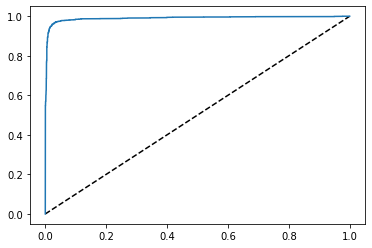

0.9901066678120928


In [22]:
fpr, tpr, _ = roc_curve(y, mnb.predict_proba(X)[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

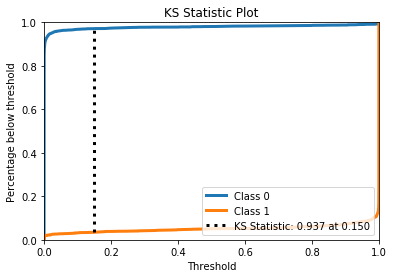

In [23]:
plot_ks_statistic(y, mnb.predict_proba(X))
plt.show()

In [24]:
confusion_matrix(y, [1 if prob >= 0.150 else 0 for prob in mnb.predict_proba(X)[:, 1]])

array([[2917,   87],
       [  79, 2246]], dtype=int64)

In [25]:
accuracy_score(y, [1 if prob >= 0.150 else 0 for prob in mnb.predict_proba(X)[:, 1]])

0.9688496903734284

In [26]:
clf = MultinomialNB()
print(cross_val_score(clf, X, y, scoring = 'roc_auc', cv=5))
# Overfitting

[0.83148158 0.86073569 0.86099333 0.84288909 0.83096416]


In [ ]:
params = {'C': np.logspace(-5, 5, 30)}
logit = LogisticRegression(penalty = 'l1', solver = 'liblinear')
clf = GridSearchCV(logit, params, cv=5, scoring = 'roc_auc').fit(X, y)
clf.best_params_, clf.best_score_

In [42]:
logit = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = clf.best_params_['C']).fit(X, y)

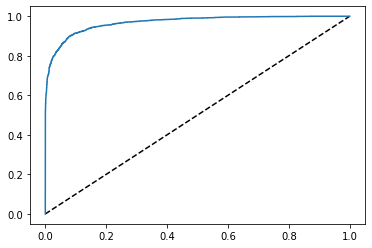

0.9684084303366121


In [43]:
fpr, tpr, _ = roc_curve(y, logit.predict_proba(X)[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

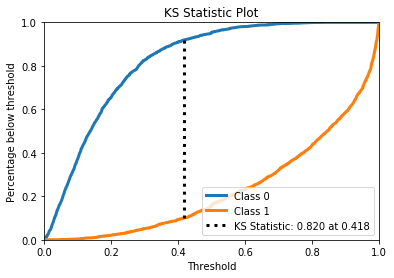

In [44]:
plot_ks_statistic(y, logit.predict_proba(X))
plt.show()

In [45]:
confusion_matrix(y, [1 if prob >= 0.418 else 0 for prob in logit.predict_proba(X)[:, 1]])

array([[2761,  243],
       [ 232, 2093]], dtype=int64)

In [46]:
accuracy_score(y, [1 if prob >= 0.418 else 0 for prob in logit.predict_proba(X)[:, 1]])

0.9108650778757741

In [47]:
clf.cv_results_

{'mean_fit_time': array([ 73.8942256 ,  75.28606691,  73.13794093,  72.29511366,
         73.08879442, 128.83826799, 137.70819325, 138.00351491,
        131.04162316, 130.5105947 ]),
 'std_fit_time': array([ 6.2414916 ,  2.99853331,  3.63523011,  4.42536258,  2.25989177,
        23.03797125,  3.95743874,  3.15563065,  7.34968086,  3.68551487]),
 'mean_score_time': array([ 6.18750348,  6.18773327,  6.00699329,  5.84423246,  5.9634706 ,
        14.77905755, 14.89516397, 14.55996661, 14.22990065, 14.3682188 ]),
 'std_score_time': array([0.32916298, 0.06563556, 0.23507652, 0.29219389, 0.20162461,
        0.43377201, 0.30051673, 0.16469972, 0.22049508, 0.33783757]),
 'param_C': masked_array(data=[1.0, 3.5938136638046276, 12.91549665014884,
                    46.4158883361278, 166.81005372000593,
                    599.4842503189409, 2154.4346900318847,
                    7742.636826811277, 27825.59402207126, 100000.0],
              mask=[False, False, False, False, False, False, False, 

In [48]:
params = {'max_depth': [10, 20, 30, 40, 50]}
rf = RandomForestClassifier(n_estimators=100)
clf = GridSearchCV(rf, params, cv=5, scoring = 'roc_auc').fit(X, y)
clf.best_params_, clf.best_score_

({'max_depth': 50}, 0.8258988155940814)

In [49]:
rf = RandomForestClassifier(n_estimators=100, max_depth = clf.best_params_['max_depth']).fit(X, y)

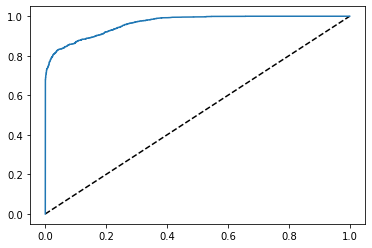

0.9639377604054807


In [50]:
fpr, tpr, _ = roc_curve(y, rf.predict_proba(X)[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

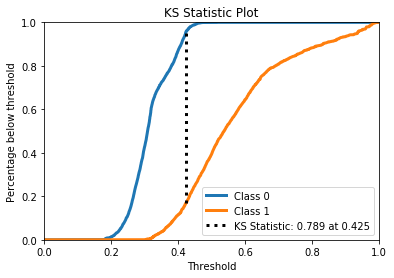

In [51]:
plot_ks_statistic(y, rf.predict_proba(X))
plt.show()

In [52]:
confusion_matrix(y, [1 if prob >= 0.425 else 0 for prob in rf.predict_proba(X)[:, 1]])

array([[2883,  121],
       [ 400, 1925]], dtype=int64)

In [53]:
accuracy_score(y, [1 if prob >= 0.425 else 0 for prob in rf.predict_proba(X)[:, 1]])

0.9022330643647964

In [54]:
clf.cv_results_
# Overfitting

{'mean_fit_time': array([41.45814195, 43.79035525, 47.79407425, 51.42782488, 55.26309705]),
 'std_fit_time': array([1.39455776, 1.3839022 , 0.72612264, 1.13266667, 0.69665139]),
 'mean_score_time': array([5.60845346, 5.52471142, 5.48672032, 5.6350203 , 5.41697497]),
 'std_score_time': array([0.05304039, 0.07371262, 0.05108197, 0.3547517 , 0.03967226]),
 'param_max_depth': masked_array(data=[10, 20, 30, 40, 50],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 10},
  {'max_depth': 20},
  {'max_depth': 30},
  {'max_depth': 40},
  {'max_depth': 50}],
 'split0_test_score': array([0.80547475, 0.81610577, 0.8222586 , 0.82991788, 0.82336429]),
 'split1_test_score': array([0.7979085 , 0.82105988, 0.82580824, 0.8281699 , 0.83580234]),
 'split2_test_score': array([0.80480024, 0.83374126, 0.83110407, 0.83921779, 0.83897805]),
 'split3_test_score': array([0.809647  , 0.82161094, 0.82364518, 0.81495178, 0.82691392]

In [56]:
features_logit = list(np.array(X.columns.tolist())[logit.coef_[0] != 0])
features_logit

['location_Australia',
 'location_California, USA',
 'location_Canada',
 'location_Florida',
 'location_Houston, TX',
 'location_Illinois, USA',
 'location_Indiana',
 'location_Kashmir!',
 'location_Leeds, England',
 'location_Los Angeles, CA',
 'location_NYC',
 'location_Nashville, TN',
 'location_Nigeria',
 'location_Not mentioned',
 'location_Pennsylvania, USA',
 'location_Tennessee',
 'location_Texas',
 'location_USA',
 'location_United States',
 'location_Worldwide',
 'location_canada',
 'location_china',
 'location_far away',
 'location_nyc',
 'keyword_Not mentioned',
 'keyword_ablaze',
 'keyword_aftershock',
 'keyword_annihilation',
 'keyword_armageddon',
 'keyword_army',
 'keyword_arsonist',
 'keyword_bioterrorism',
 'keyword_blaze',
 'keyword_blazing',
 'keyword_bleeding',
 'keyword_blight',
 'keyword_blizzard',
 'keyword_blood',
 'keyword_bloody',
 'keyword_buildings%20burning',
 'keyword_burning%20buildings',
 'keyword_casualties',
 'keyword_catastrophe',
 'keyword_chemical%

In [57]:
mnb_logit = MultinomialNB().fit(X[features_logit], y)

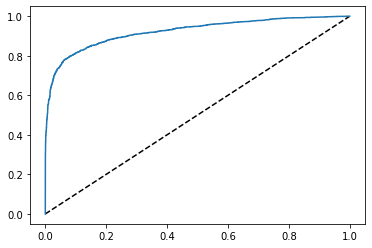

0.9222158985152413


In [58]:
fpr, tpr, _ = roc_curve(y, mnb_logit.predict_proba(X[features_logit])[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

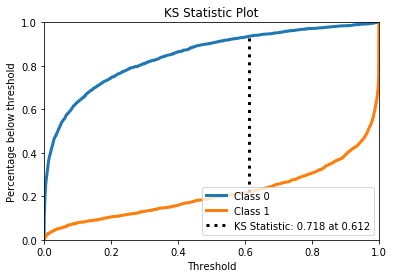

In [59]:
plot_ks_statistic(y, mnb_logit.predict_proba(X[features_logit]))
plt.show()

In [60]:
confusion_matrix(y, [1 if prob >= 0.612 else 0 for prob in mnb_logit.predict_proba(X[features_logit])[:, 1]])

array([[2811,  193],
       [ 507, 1818]], dtype=int64)

In [61]:
accuracy_score(y, [1 if prob >= 0.612 else 0 for prob in mnb_logit.predict_proba(X[features_logit])[:, 1]])

0.8686432726590355

In [62]:
clf = MultinomialNB()
print(cross_val_score(clf, X[features_logit], y, scoring = 'roc_auc', cv=5))

[0.87537617 0.90917109 0.89340168 0.88970712 0.86205376]


In [64]:
pd.DataFrame({'features': X.columns,
              'Importance': rf.feature_importances_}).sort_values('Importance', ascending = False).head(20)

,features,Importance
32709,bow_corners,0.026312
15410,bow_rule catastrophic,0.016240
32710,bow_a9bnlse6qb,0.013091
42689,bow_japan marked,0.007811
69477,bow_emiliorivera48 davidlabrava,0.007661
33504,bow_lead http,0.007202
57831,bow_muschamp,0.007101
37083,bow_gusts,0.006846
26532,bow_mapleridge lougheed,0.006065
26417,bow_rejects against,0.005954


In [65]:
temp = pd.DataFrame({'features': X.columns,
              'Importance': rf.feature_importances_})
temp = temp.sort_values('Importance', ascending = False)
features_rf = temp.iloc[:500, 0].tolist()
features_rf

['bow_corners',
 'bow_rule catastrophic',
 'bow_a9bnlse6qb',
 'bow_japan marked',
 'bow_emiliorivera48 davidlabrava',
 'bow_lead http',
 'bow_muschamp',
 'bow_gusts',
 'bow_mapleridge lougheed',
 'bow_rejects against',
 'bow_is fucked',
 'bow_nws posts',
 'bow_got her',
 'bow_philly was',
 'bow_9e2f7bivle youtube',
 'bow_is actually',
 'bow_up some',
 'bow_pat',
 'bow_the lions',
 'bow_comin soon',
 'bow_she still',
 'bow_his guards',
 'bow_hired really',
 'keyword_derailment',
 'bow_amp ignore',
 'bow_sinjar has',
 'bow_tneazzy mizzou',
 'bow_wreckage confirmation',
 'bow_07',
 'bow_applications',
 'bow_wactt18gda',
 'bow_drivers',
 'bow_now even',
 'keyword_oil%20spill',
 'bow_pak they',
 'bow_good lol',
 'bow_lookss',
 'keyword_wild%20fires',
 'bow_tuning http',
 'bow_es',
 'bow_fantasy stock',
 'bow_sailing',
 'bow_bombing you',
 'bow_is whole',
 'bow_summer my',
 'keyword_forest%20fires',
 'bow_more devastated',
 'bow_cars aka',
 'bow_lqd1wefpqd http',
 'bow_y8orqapwrk',
 'bow_mag

In [66]:
mnb_rf = MultinomialNB().fit(X[features_rf], y)

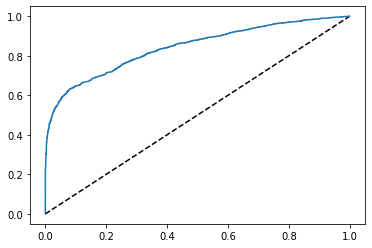

0.8414851882078376


In [67]:
fpr, tpr, _ = roc_curve(y, mnb_rf.predict_proba(X[features_rf])[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

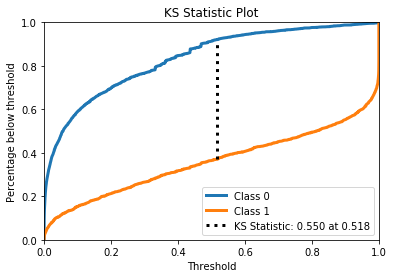

In [68]:
plot_ks_statistic(y, mnb_rf.predict_proba(X[features_rf]))
plt.show()

In [69]:
confusion_matrix(y, [1 if prob >= 0.518 else 0 for prob in mnb_rf.predict_proba(X[features_rf])[:, 1]])

array([[2768,  236],
       [ 866, 1459]], dtype=int64)

In [70]:
accuracy_score(y, [1 if prob >= 0.518 else 0 for prob in mnb_rf.predict_proba(X[features_rf])[:, 1]])

0.7932069806717958

In [71]:
clf = MultinomialNB()
print(cross_val_score(clf, X[features_rf], y, scoring = 'roc_auc', cv=5))
# A bit overfitting

[0.81657453 0.84147031 0.85102249 0.83064963 0.80666129]


# Model Evaluation

In [72]:
test_bow = add_bow(test, bow)

In [88]:
test_X = test_bow.iloc[:, 1:]
test_y = test_bow.iloc[:, 0]

In [89]:
accuracy_score(y, [1 if prob >= 0.612 else 0 for prob in mnb_logit.predict_proba(X[features_logit])[:, 1]])

0.8686432726590355

In [90]:
accuracy_score(test_y, [1 if prob >= 0.612 else 0 for prob in mnb_logit.predict_proba(test_X[features_logit])[:, 1]])

0.8029772329246935

In [91]:
confusion_matrix(y, [1 if prob >= 0.612 else 0 for prob in mnb_logit.predict_proba(X[features_logit])[:, 1]])

array([[2811,  193],
       [ 507, 1818]], dtype=int64)

In [92]:
confusion_matrix(test_y, [1 if prob >= 0.612 else 0 for prob in mnb_logit.predict_proba(test_X[features_logit])[:, 1]])

array([[1182,  156],
       [ 294,  652]], dtype=int64)

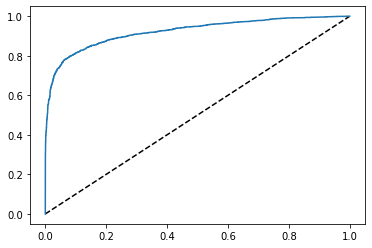

0.9222158985152413


In [93]:
fpr, tpr, _ = roc_curve(y, mnb_logit.predict_proba(X[features_logit])[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

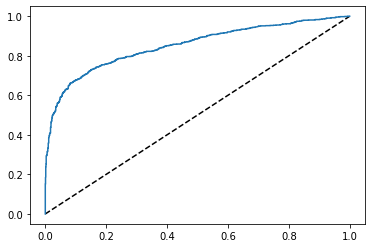

0.8512484317573483


In [94]:
fpr, tpr, _ = roc_curve(test_y, mnb_logit.predict_proba(test_X[features_logit])[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

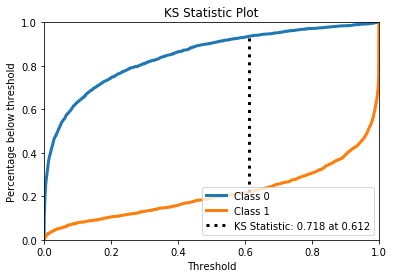

In [95]:
plot_ks_statistic(y, mnb_logit.predict_proba(X[features_logit]))
plt.show()

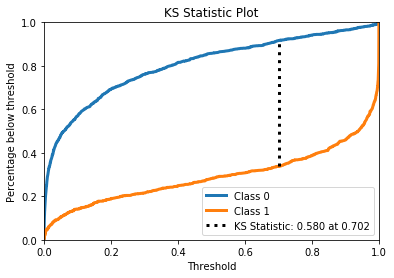

In [96]:
plot_ks_statistic(test_y, mnb_logit.predict_proba(test_X[features_logit]))
plt.show()

# Prediction

In [86]:
bow = CountVectorizer(ngram_range = (1, 2)).fit(data_rescale['text'])

In [87]:
data_bow = add_bow(data_rescale, bow)

In [97]:
X = data_bow.iloc[:, 1:]
y = data_bow.iloc[:, 0]

In [98]:
params = {'C': np.logspace(-5, 5, 30)}
logit = LogisticRegression(penalty = 'l1', solver = 'liblinear')
clf = GridSearchCV(logit, params, cv=5, scoring = 'roc_auc').fit(X, y)
clf.best_params_, clf.best_score_

KeyboardInterrupt: 

In [ ]:
logit = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = clf.best_params_['C']).fit(X, y)

In [ ]:
features_logit = list(np.array(X.columns.tolist())[logit.coef_[0] != 0])
features_logit

In [233]:
mnb_logit = MultinomialNB().fit(X[features_logit], y)

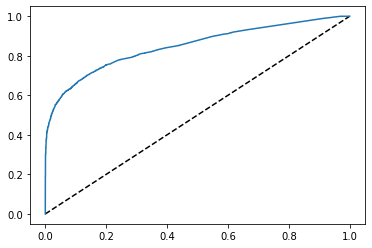

0.8478996431800698


In [234]:
fpr, tpr, _ = roc_curve(y, logit.predict_proba(X)[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

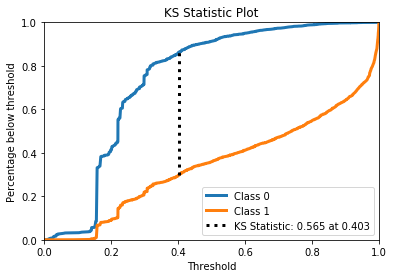

In [235]:
plot_ks_statistic(y, logit.predict_proba(X))
plt.show()

In [236]:
confusion_matrix(y, [1 if prob >= 0.403 else 0 for prob in logit.predict_proba(X)[:, 1]])

array([[3743,  599],
       [ 976, 2295]], dtype=int64)

In [237]:
accuracy_score(y, [1 if prob >= 0.403 else 0 for prob in logit.predict_proba(X)[:, 1]])

0.7931170366478392

In [238]:
predict = pd.read_csv('../../data/Disaster/test.csv', index_col = 0)
predict.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [239]:
predict['location'] = predict['location'].fillna('Not mentioned')
predict.head()

,keyword,location,text
id,,,
0,NaN,Not mentioned,Just happened a terrible car crash
2,NaN,Not mentioned,"Heard about #earthquake is different cities, s..."
3,NaN,Not mentioned,"there is a forest fire at spot pond, geese are..."
9,NaN,Not mentioned,Apocalypse lighting. #Spokane #wildfires
11,NaN,Not mentioned,Typhoon Soudelor kills 28 in China and Taiwan


In [240]:
predict['keyword'] = predict['keyword'].fillna('Not mentioned')
predict.head()

,keyword,location,text
id,,,
0,Not mentioned,Not mentioned,Just happened a terrible car crash
2,Not mentioned,Not mentioned,"Heard about #earthquake is different cities, s..."
3,Not mentioned,Not mentioned,"there is a forest fire at spot pond, geese are..."
9,Not mentioned,Not mentioned,Apocalypse lighting. #Spokane #wildfires
11,Not mentioned,Not mentioned,Typhoon Soudelor kills 28 in China and Taiwan


In [242]:
predict = add_dummy(predict, onehot)
predict.head()

In [243]:
predict = add_bow(predict, bow)
predict.head()

,location_,location_ Glasgow,"location_ Melbourne, Australia",location_ News,location_ å_,location_ 45å¡ 5'12.53N 14å¡ 7'24.93E,"location_ 616 Û¢ Kentwood , MI",location_ ? ??????? ? ( ?? å¡ ? ? ? å¡),location_ ?currently writing a book?,location_ Alberta,...,bow_reuters via,bow_via world,bow_world google,bow_google news,bow_news wall,bow_co nf4iculoje,bow_stfmbbzfb5,bow_co stfmbbzfb5,bow_ymy4rskq3d,bow_co ymy4rskq3d
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [244]:
sample = pd.DataFrame(index = predict.index)
sample['target'] = [1 if prob >= 0.403 else 0 for prob in logit.predict_proba(predict[features])[:, 1]]
sample.head()

,target
id,
0,1
2,1
3,1
9,0
11,1


In [246]:
sample.to_csv('../../data/Disaster/submission.csv')